In [ ]:
#%tensorflow_version 1.x

In [ ]:
! pip install keras-unet

In [ ]:
! pip install -U segmentation-models

In [ ]:
import os
import sys
import glob
#import h5py
import albumentations as A
from PIL import Image
from pathlib import Path
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imshow
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.morphology import label
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, SpatialDropout2D, Add
from keras.layers import Concatenate, ZeroPadding2D, concatenate, Activation,  UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras_unet.utils import plot_imgs
from keras_unet.metrics import iou, iou_thresholded
import segmentation_models as sm
import keras
sm.set_framework('tf.keras')
sm.framework()
keras.backend.set_image_data_format('channels_last')

import tensorflow as tf
import cv2

# to supress warnings from skimage
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
plt.rcParams["axes.grid"] = False

ImportError: ignored

### Load Train and Test Data

In [ ]:
def load_data(image_path, mask_path, dims):
  imgs = glob.glob(os.path.join(image_path, '*.tif'))
  mks = glob.glob(os.path.join(mask_path, '*.tif'))
  print(f"Found {len(imgs)} images and masks.")
  sys.stdout.flush()

  imgs_lst = []
  mks_lst = []

  print("Processing images...")
  sys.stdout.flush()
  for image, mask in tqdm(zip(imgs, mks), total=len(imgs)):
      imgs_lst.append(np.array(Image.open(image).convert('L').resize((dims, dims))))
      mks_lst.append(np.array(Image.open(mask).convert('L').resize((dims, dims))))

  sys.stdout.flush()
  images = np.expand_dims(np.asarray(imgs_lst), axis=-1)
  masks = np.expand_dims(np.asarray(mks_lst), axis=-1)

  return images, masks

In [ ]:
images_path = '/content/drive/MyDrive/hydra/train/images/'
masks_path = '/content/drive/MyDrive/hydra/train/masks/'

images, masks = load_data(images_path, masks_path, 256)

Found 24 images and masks.
Processing images...


100%|██████████| 24/24 [00:01<00:00, 23.05it/s]


In [ ]:
print(f"Image data shape: {images.shape}")
print(f"Mask data shape: {masks.shape}")

Image data shape: (24, 256, 256, 1)
Mask data shape: (24, 256, 256, 1)


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.3, random_state=42)

In [ ]:
# create generator (1.0/255.0 = 0.003921568627451)
generator = ImageDataGenerator(rescale=1.0/255.0)
# prepare an iterators to scale images
train_iterator = generator.flow(X_train, Y_train, batch_size=2)
val_iterator = generator.flow(X_val, Y_val, batch_size=2)
print('Batches train=%d, test=%d' % (len(train_iterator), len(val_iterator)))
# confirm the scaling works
batch_X, batch_Y = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batch_X.shape, batch_X.min(), batch_X.max()))

Batches train=8, test=4
Batch shape=(2, 256, 256, 1), min=0.396, max=1.000


### Inspect a few train images

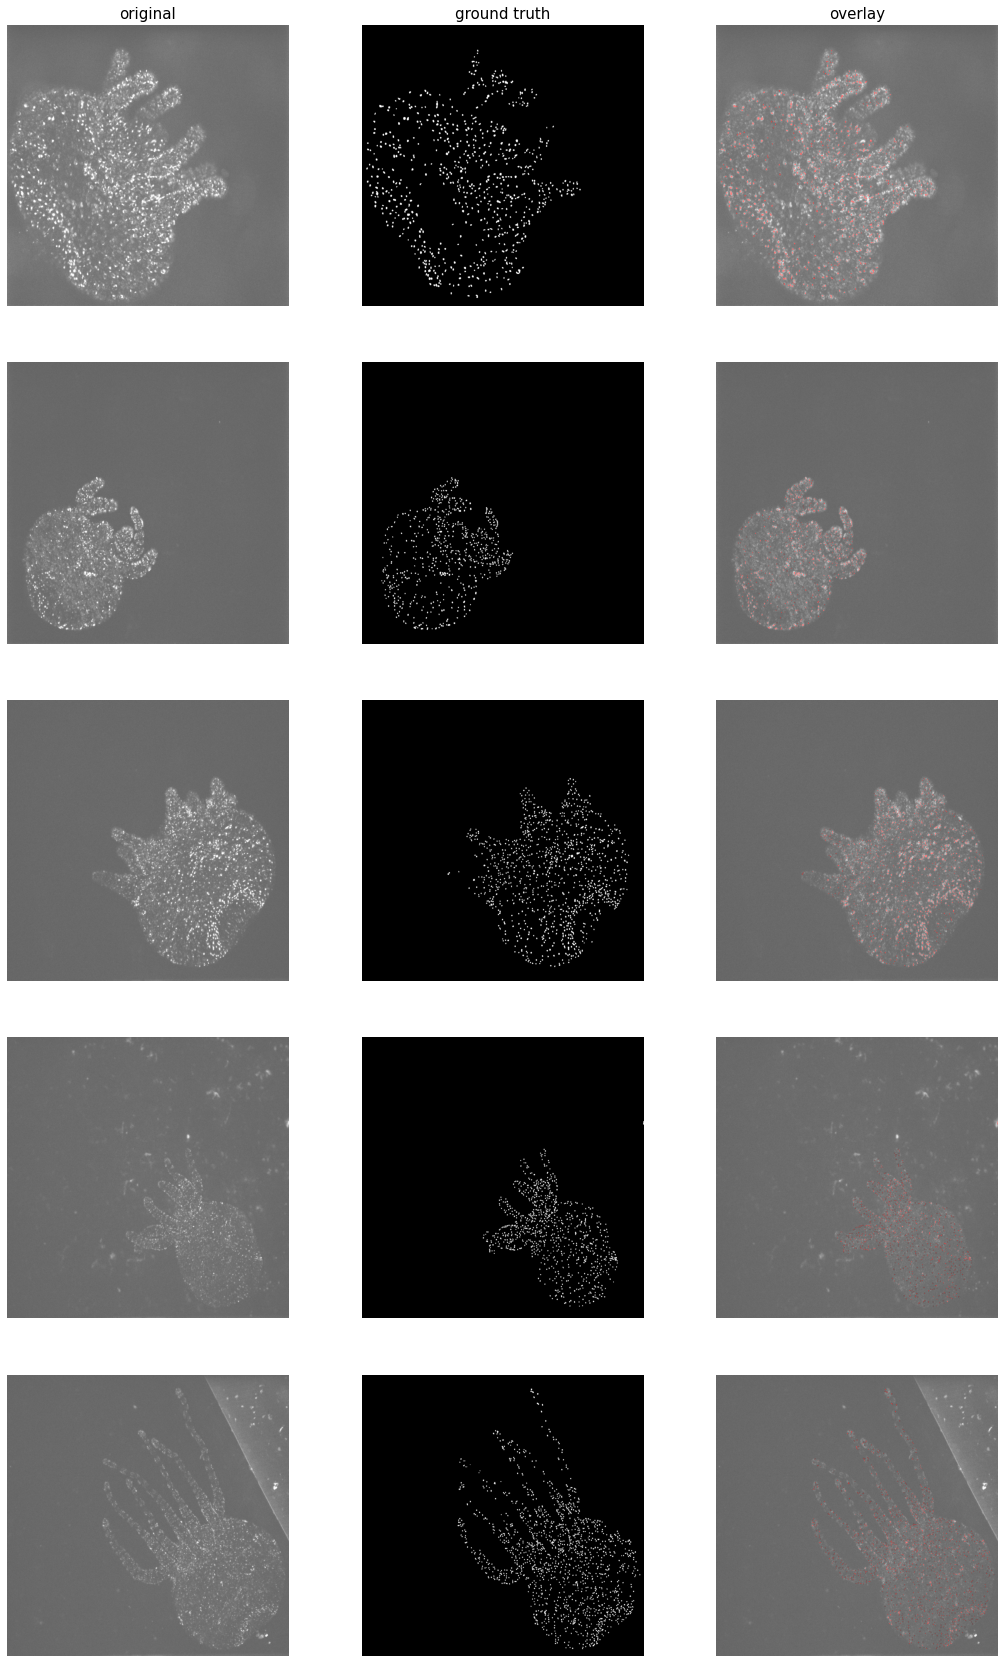

In [ ]:
plot_imgs(org_imgs=images.astype(np.uint8), mask_imgs=masks.astype(bool), nm_img_to_plot=5, figsize=6)

## Test-Train Split

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.3, random_state=42)

## Data Augmentation

In [ ]:
def get_augmentations():
    train_transform = [
        A.CenterCrop(height=128, width=128, always_apply=True),
        A.VerticalFlip(always_apply=True),
        A.HorizontalFlip(always_apply=True),
        A.Rotate(p=0.6),
    ]
    train_aug = A.Compose(train_transform)

    val_transform = [
        A.CenterCrop(height=128, width=128)          
    ]

    val_aug = A.Compose(val_transform)

    return train_aug, val_aug

In [ ]:
train_aug, val_aug = get_augmentations()

In [ ]:
def augment_data(augmentation, images, masks, iters):  
  imgs, msks = [],[]
  data = zip(images, masks)
  for _, (x,y) in tqdm(enumerate(data)):
    for i in range(iters):
      augmented = augmentation(image=x, mask=y)
      imgs.append(augmented['image'])
      msks.append(augmented['mask'])

  images_aug = np.asarray(imgs)
  masks_aug = np.asarray(msks, bool)

  return images_aug, masks_aug

In [ ]:
X_train_aug, Y_train_aug = augment_data(train_aug, X_train, Y_train, 500)

16it [00:03,  4.42it/s]


In [ ]:
X_val_aug, Y_val_aug = augment_data(val_aug, X_val, Y_val, 500)

8it [00:00, 168.09it/s]


In [ ]:
def show_random_image(X_train, Y_train):
  idx = random.randint(0, X_train.shape[0])
  plt.figure(figsize=(12,6))
  plt.subplot(121)
  plt.imshow(np.squeeze(X_train[idx]), cmap='gray')
  plt.title("Image")
  plt.subplot(122)
  plt.imshow(np.squeeze(Y_train[idx]), cmap='gray')
  plt.title("Mask")
  plt.show()

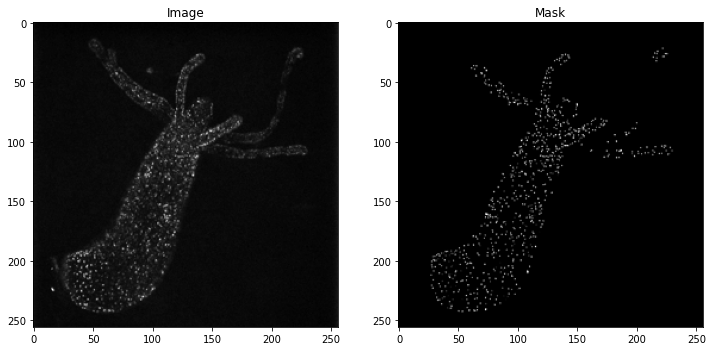

In [ ]:
show_random_image(X_train, Y_train)

# Train U-Net Model

In [ ]:
def build_model(img_width, img_height, num_channels, activation='elu'):
  inputs = Input((img_width, img_height, num_channels))
  s = Lambda(lambda x: x / 255) (inputs)

  # contraction branch
  c1 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c5)

  # expansion branch
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [ ]:
img_height = X_train.shape[1]
img_width = X_train.shape[2]
num_channels = X_train.shape[3]

model = build_model(128, 128, 3)

In [ ]:
# fitting the model with generator
#model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),
#                    epochs=5)

In [ ]:
#es = EarlyStopping(patience=5, verbose=1)
model_filename = 'hydra_final.h5'
cb = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [ ]:
precision = sm.metrics.Precision(name='precision')
recall = sm.metrics.Recall(name='recall')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou, iou_thresholded])
results = model.fit(X_train_aug, Y_train_aug, batch_size=32, validation_data=(X_val_aug, Y_val_aug),
                    epochs=50, callbacks=[cb])

Epoch 1/50
250/250 [==============================] - 16s 54ms/step - loss: 0.0607 - iou: 0.5435 - iou_thresholded: 0.6396 - val_loss: 0.0714 - val_iou: 0.4649 - val_iou_thresholded: 0.6074

Epoch 00001: val_loss improved from inf to 0.07141, saving model to hydra_final.h5
Epoch 2/50
250/250 [==============================] - 13s 50ms/step - loss: 0.0239 - iou: 0.7362 - iou_thresholded: 0.8055 - val_loss: 0.0714 - val_iou: 0.4904 - val_iou_thresholded: 0.6140

Epoch 00002: val_loss improved from 0.07141 to 0.07138, saving model to hydra_final.h5
Epoch 3/50
250/250 [==============================] - 13s 51ms/step - loss: 0.0204 - iou: 0.7676 - iou_thresholded: 0.8319 - val_loss: 0.0700 - val_iou: 0.5155 - val_iou_thresholded: 0.6212

Epoch 00003: val_loss improved from 0.07138 to 0.06997, saving model to hydra_final.h5
Epoch 4/50
250/250 [==============================] - 13s 50ms/step - loss: 0.0183 - iou: 0.7885 - iou_thresholded: 0.8476 - val_loss: 0.0687 - val_iou: 0.5164 - val_iou_

# Plot Training Results

### IoU

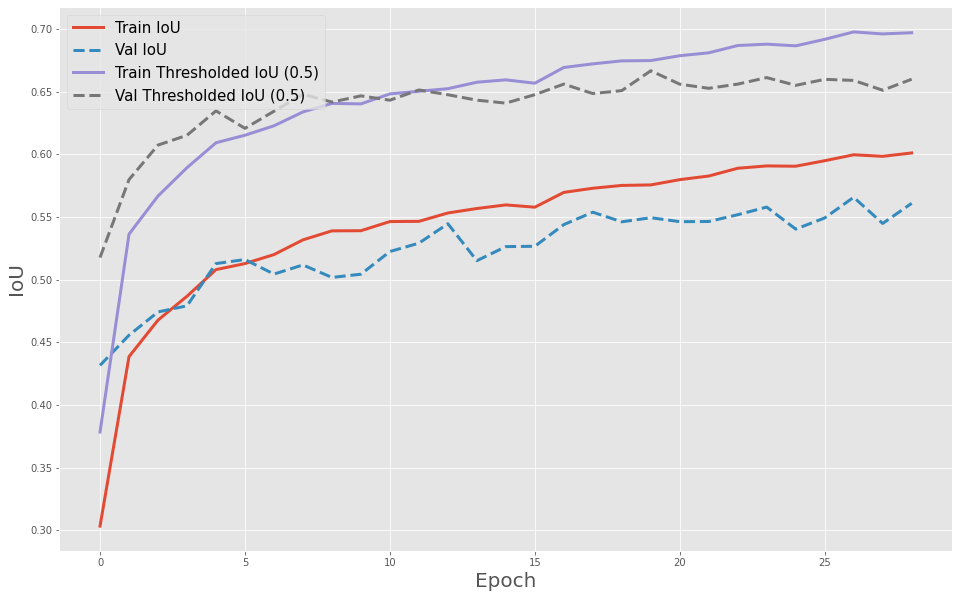

In [ ]:
plt.style.use('ggplot')
res = model.history.history
iou = res['iou']
val_iou = res['val_iou']
iou_thresh = res['iou_thresholded']
val_iou_thresh = res['val_iou_thresholded']

fig, ax = plt.subplots(figsize=(16, 10))
plt.plot(iou, label='IoU', linewidth=3)
plt.plot(val_iou, label='Val IoU', linestyle='dashed', linewidth=3)
plt.plot(iou_thresh, label = 'Thresholded IoU', linewidth=3)
plt.plot(val_iou_thresh, label='Thresholded Val IoU', linestyle='dashed', linewidth=3)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('IoU', fontsize=20)
plt.legend(['Train IoU', 'Val IoU', 'Train Thresholded IoU (0.5)', 'Val Thresholded IoU (0.5)'], loc="upper left", fontsize=15)
plt.savefig('iou_final_results.png', dpi=400)

# Evaluate Model

### Make Predictions on Test Set

In [ ]:
test_images_path = '/content/drive/MyDrive/hydra/test/images/'
test_masks_path = '/content/drive/MyDrive/hydra/test/masks/'

In [ ]:
X_val.shape

(128, 128, 3)

In [ ]:
# get predictions on the val set
Y_pred = model.predict(X_val)

ValueError: ignored

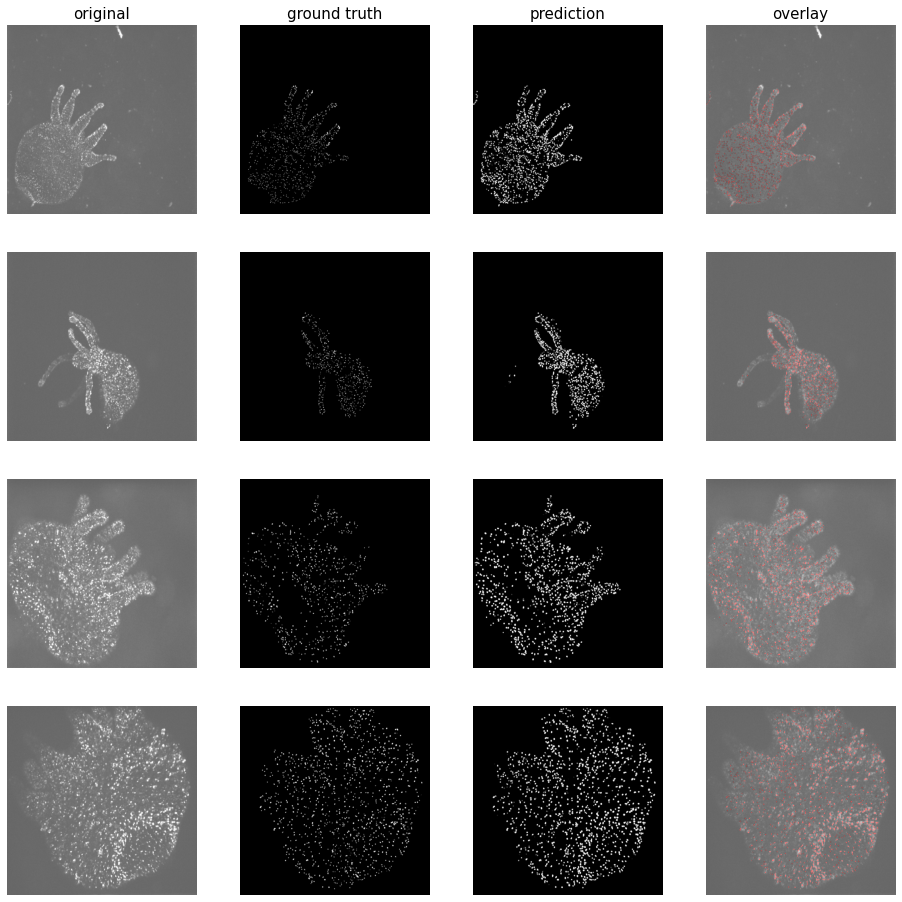

In [ ]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val.astype(np.uint8), mask_imgs=Y_val, pred_imgs=Y_pred, nm_img_to_plot=4)

## Model Evaluation

In [ ]:
_, iou = model.evaluate(X_test, Y_test)

In [ ]:
! pip install pytri

     |████████████████████████████████| 635 kB 8.5 MB/s 
     |████████████████████████████████| 3.4 MB 88.6 MB/s 
     |████████████████████████████████| 275 kB 57.2 MB/s 
  Created wheel for pytri: filename=pytri-2.0.1-py3-none-any.whl size=11878 sha256=9da8a579a13206cc698a80a7fd3d2124d2bb96803a9636be2924d60e914bc7ba
  Stored in directory: /root/.cache/pip/wheels/9e/6a/cb/15e31813d10c0680785a2d1d1191eed5f36f0559f47f9890c9
Successfully built pytri


In [ ]:
from pytri import Figure

In [ ]:
import numpy as np


In [ ]:
f = Figure()
f.axes()
f.lines(
    # 100 lines on the interval 0-100
    np.random.random((100, 2, 3)) * 100,
    # 200 colors, start/stop for each line
    colors=np.random.random((100, 2, 3)),
    width=4
)
f.show()

/usr/local/lib/python3.7/dist-packages/pytri/layers.py:46: UserWarning: Unused kwargs : {'layer_name': 'lines'}
  warn(f'Unused kwargs : {kwargs}')


HTML(value='')

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.6, position=(3.0, 5.0, 1.…

In [ ]:
y_pred = model.predict(X_test)
y_pred_tresh = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_tresh)
union = np.logical_or(y_test, y_pred_tresh)
iou_score = np.sum(intersection) / np.sum(union)
print(f"IoU is: {iou_score}")